## Persistent homology diagram analysis

This notebook analyzes the differences in persistent homology across representations and datasets.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import PurePath
from matplotlib import rc
from plotting import load_plot_config
from utils import create_subplots, plot_ph_diagrams, filter_df, convert_lists_to_arr, interval_convert, compute_2_3_ratio, compute_frac
rc('text', usetex=False) 

PROCESSED_DIR = PurePath("../topolearn/processed_data")
df = pd.read_csv(PROCESSED_DIR / "results.csv")

# Process PH diagrams
df[f"dgms"] = convert_lists_to_arr(df[f"dgms"], ragged=True)
df[f"ph_dim_logspace0"] = convert_lists_to_arr(df[f"ph_dim_logspace0"])
df[f"ph_dim_logedges0"] = convert_lists_to_arr(df[f"ph_dim_logedges0"])
df[f"intervals_0"] = df[f"dgms"].apply(interval_convert, args=[0])
df[f"intervals_1"] = df[f"dgms"].apply(interval_convert, args=[1])
df["norm_intervals_0"] = [(i - i.min())/(i.max() - i.min() + 0.0001) if isinstance(i, np.ndarray) else [] for i in df[f"intervals_0"].values]
df["norm_intervals_1"] = [(i - i.min())/(i.max() - i.min() + 0.0001) if isinstance(i, np.ndarray) else [] for i in df[f"intervals_1"].values]

#### Plot 1: Persistence Diagram per representation and dataset

100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


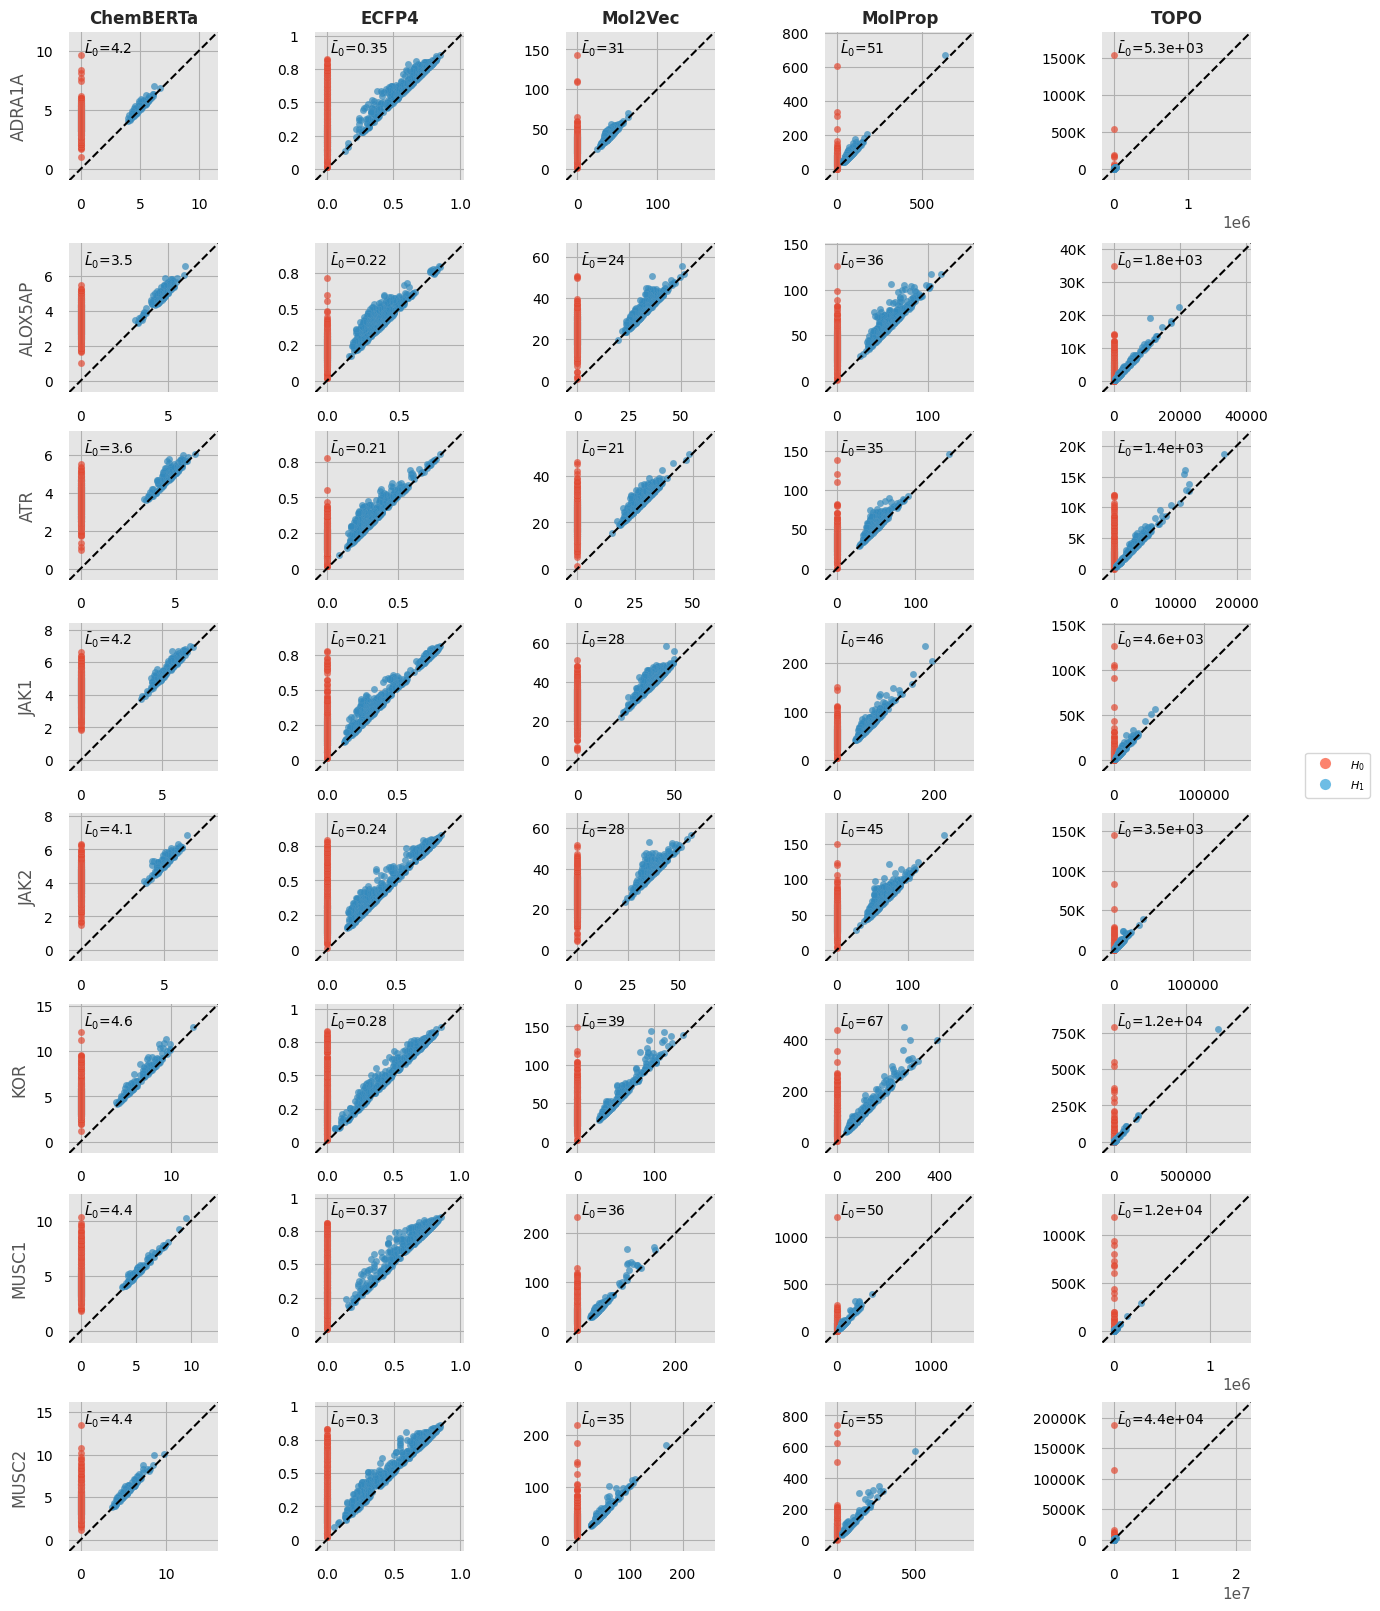

100%|██████████| 20/20 [00:01<00:00, 13.20it/s]


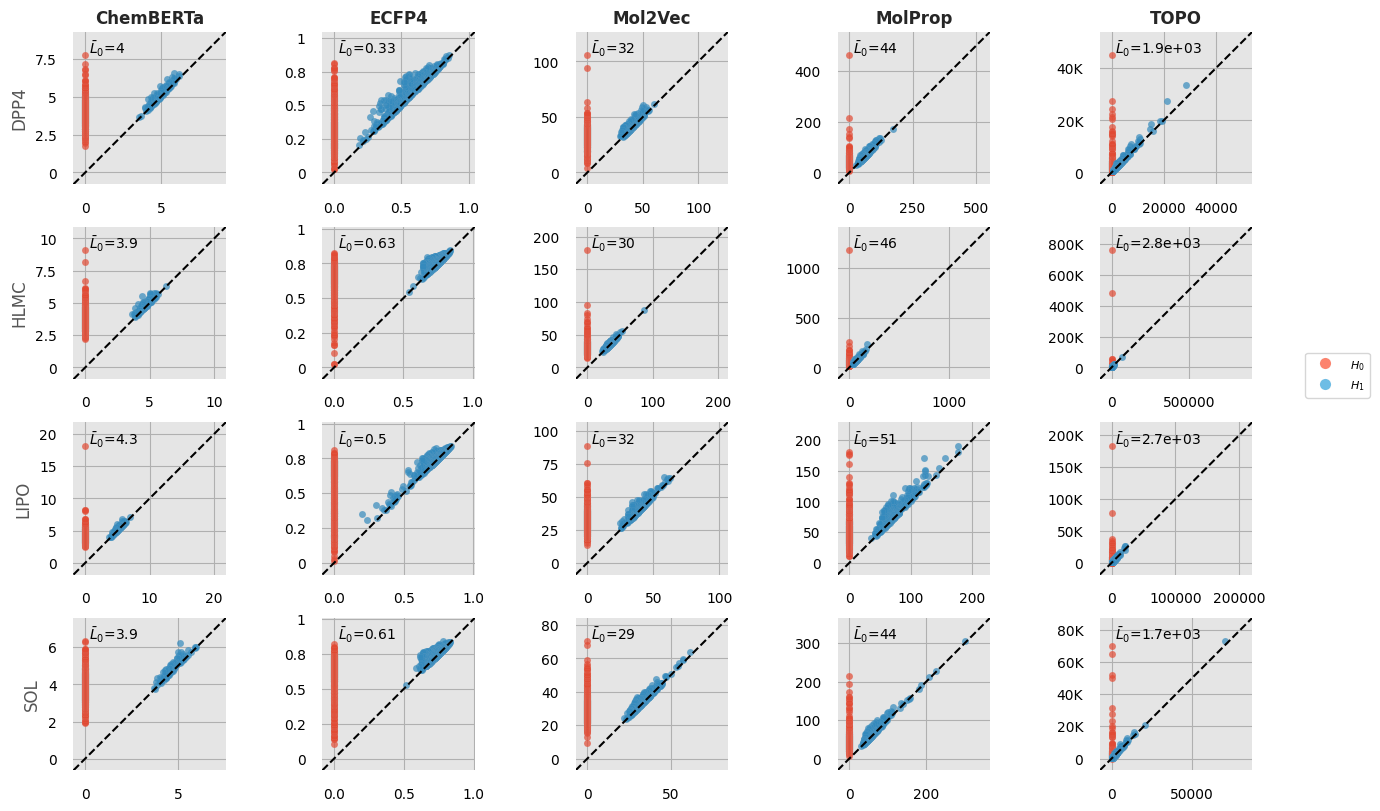

100%|██████████| 40/40 [00:05<00:00,  7.18it/s]


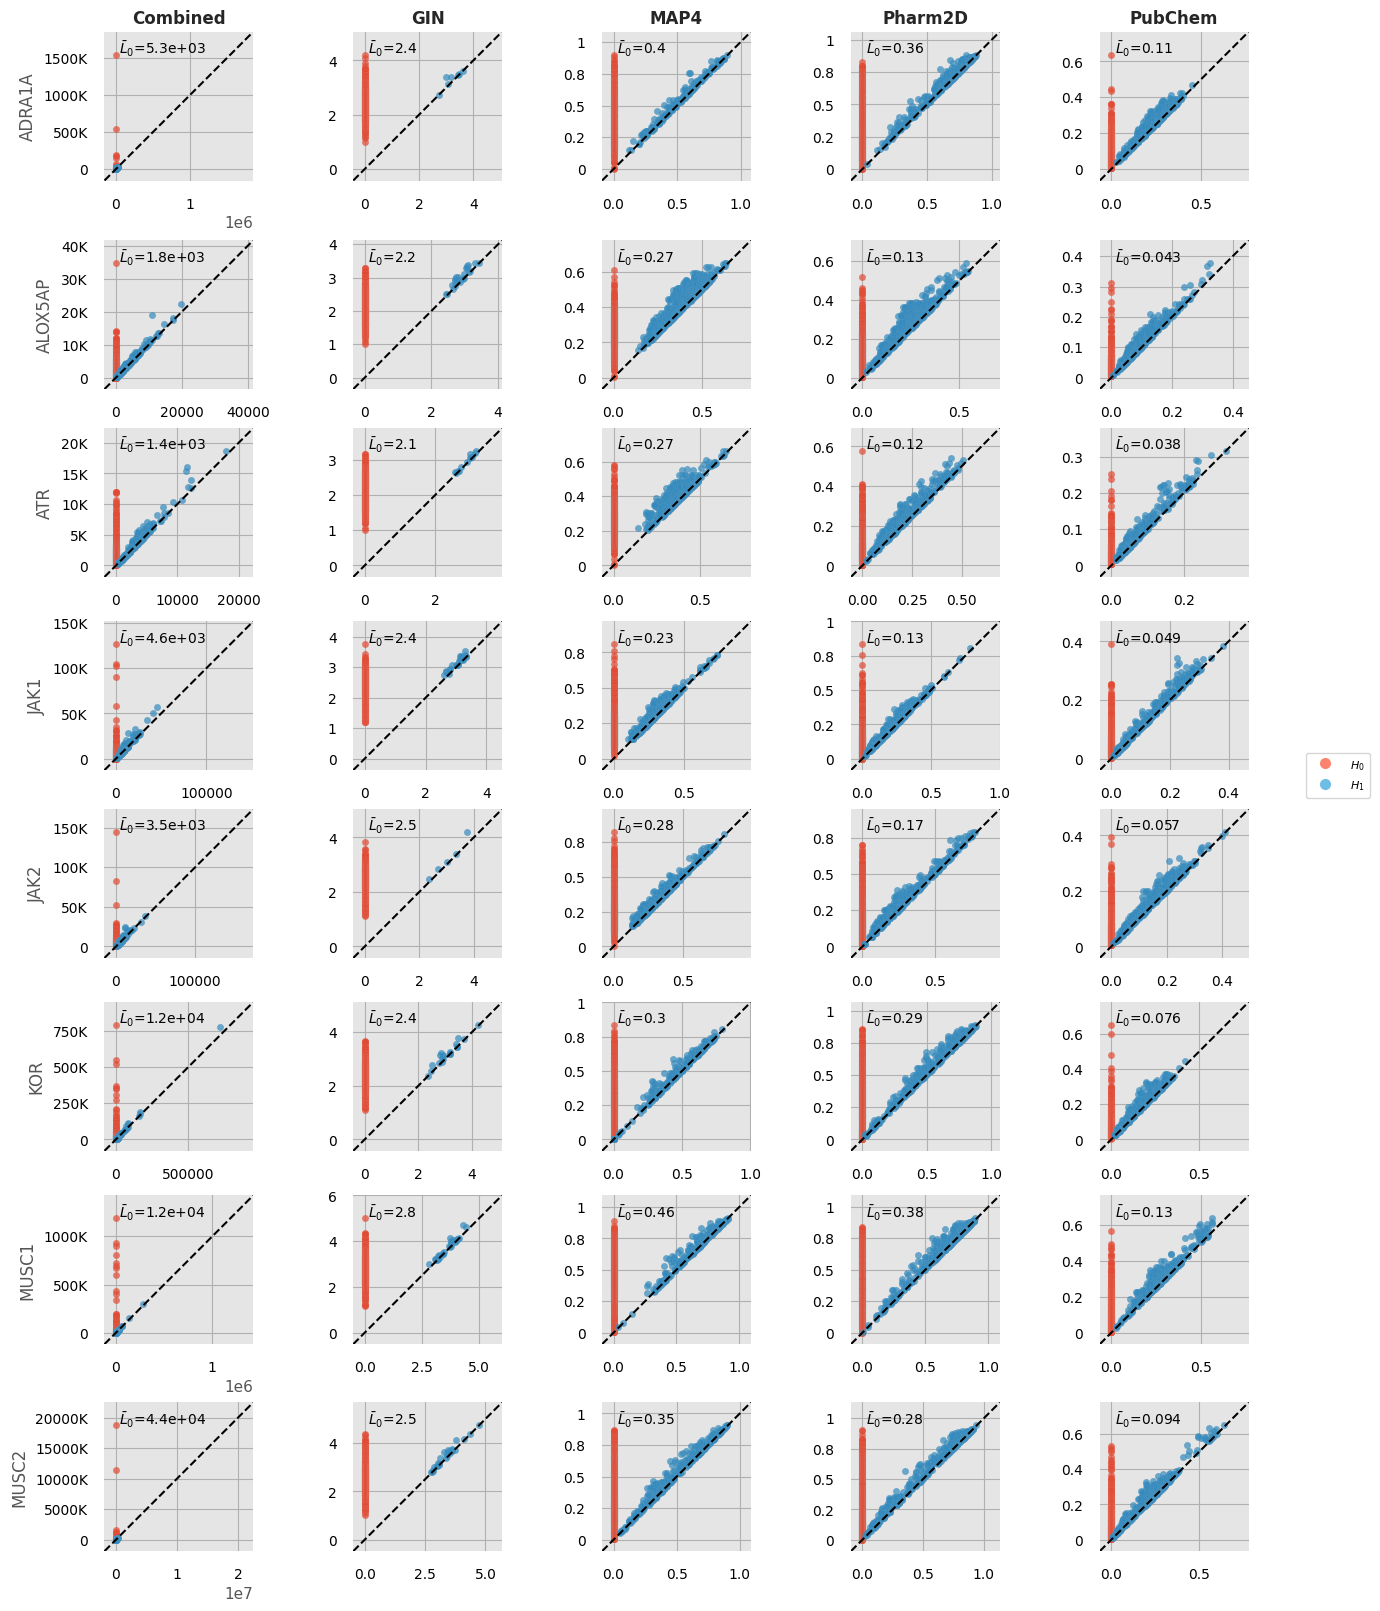

100%|██████████| 20/20 [00:01<00:00, 13.23it/s]


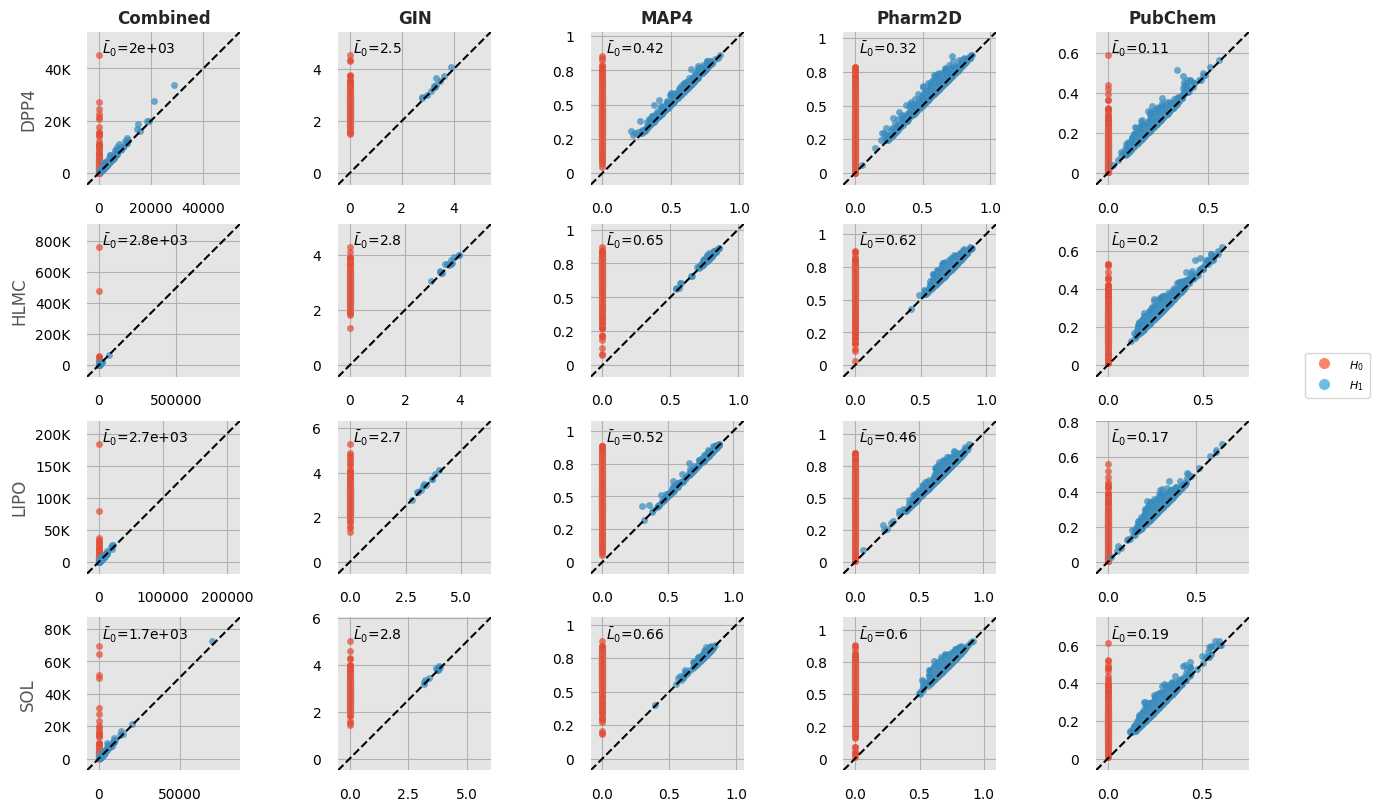

100%|██████████| 16/16 [00:01<00:00, 13.09it/s]


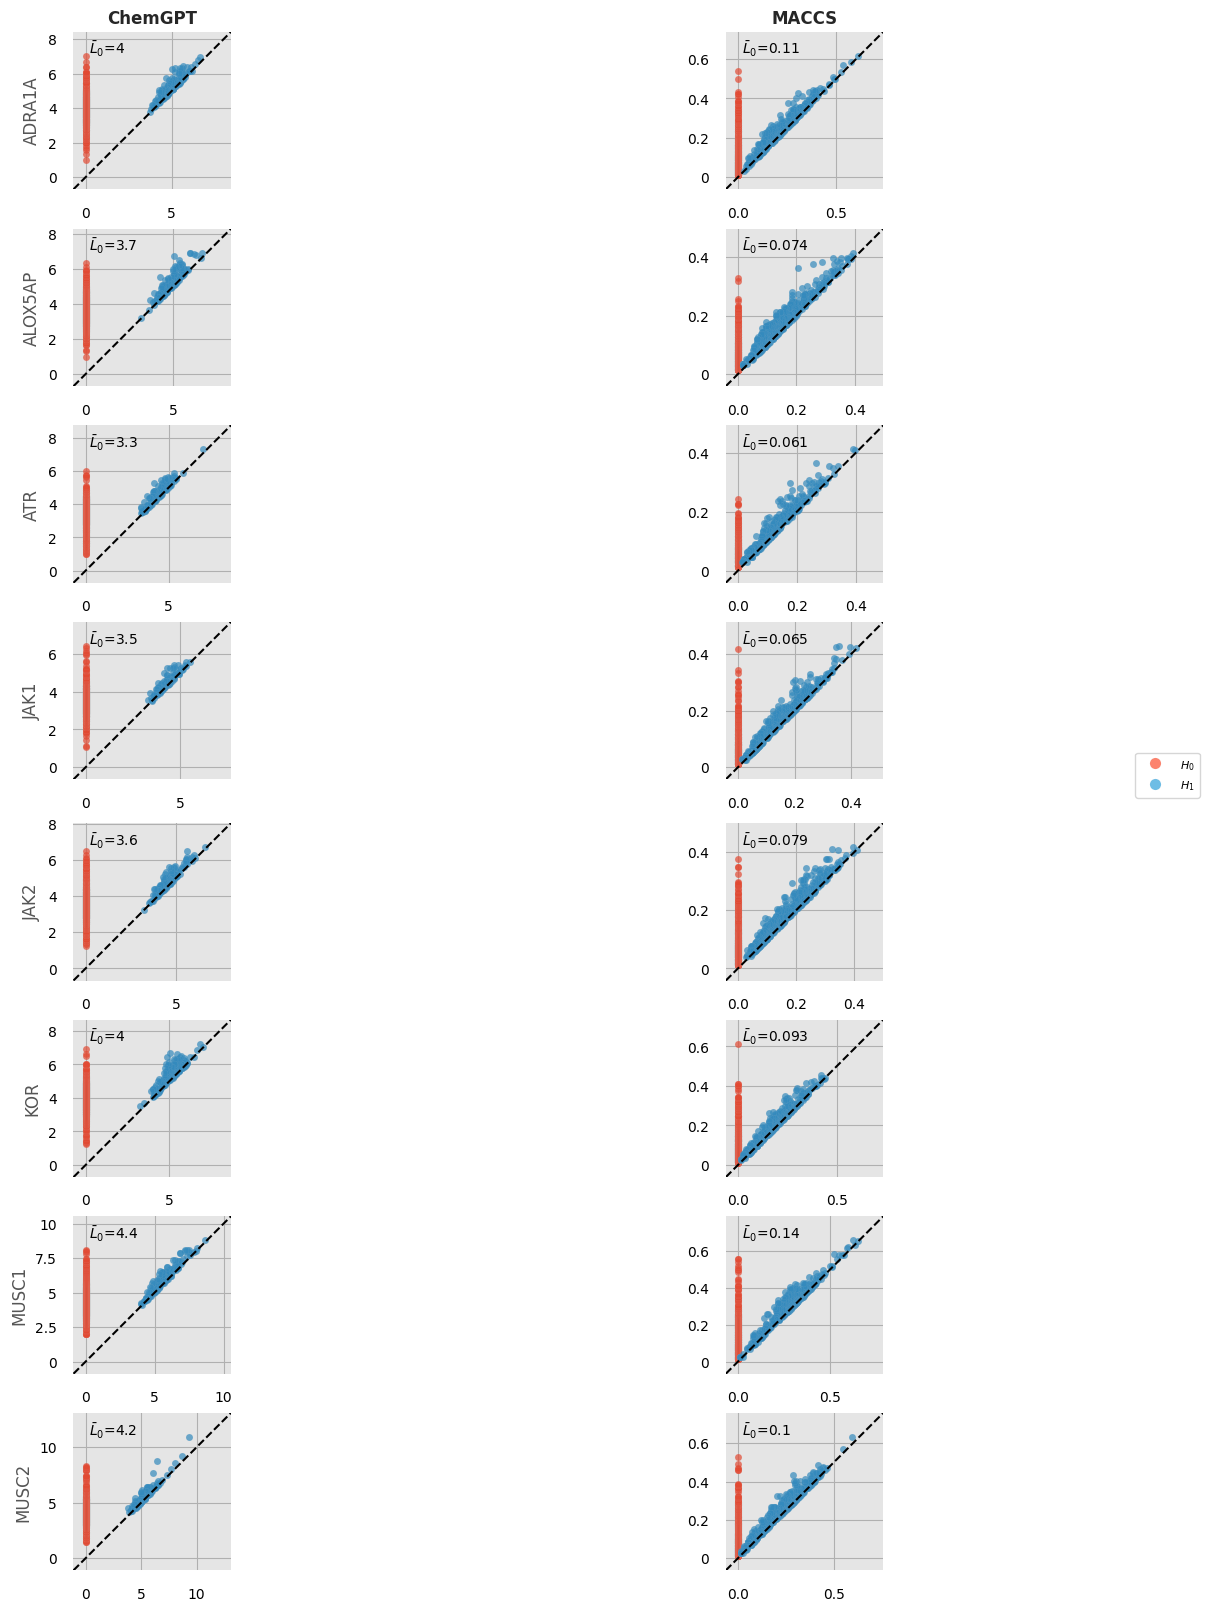

100%|██████████| 8/8 [00:00<00:00, 36.49it/s]


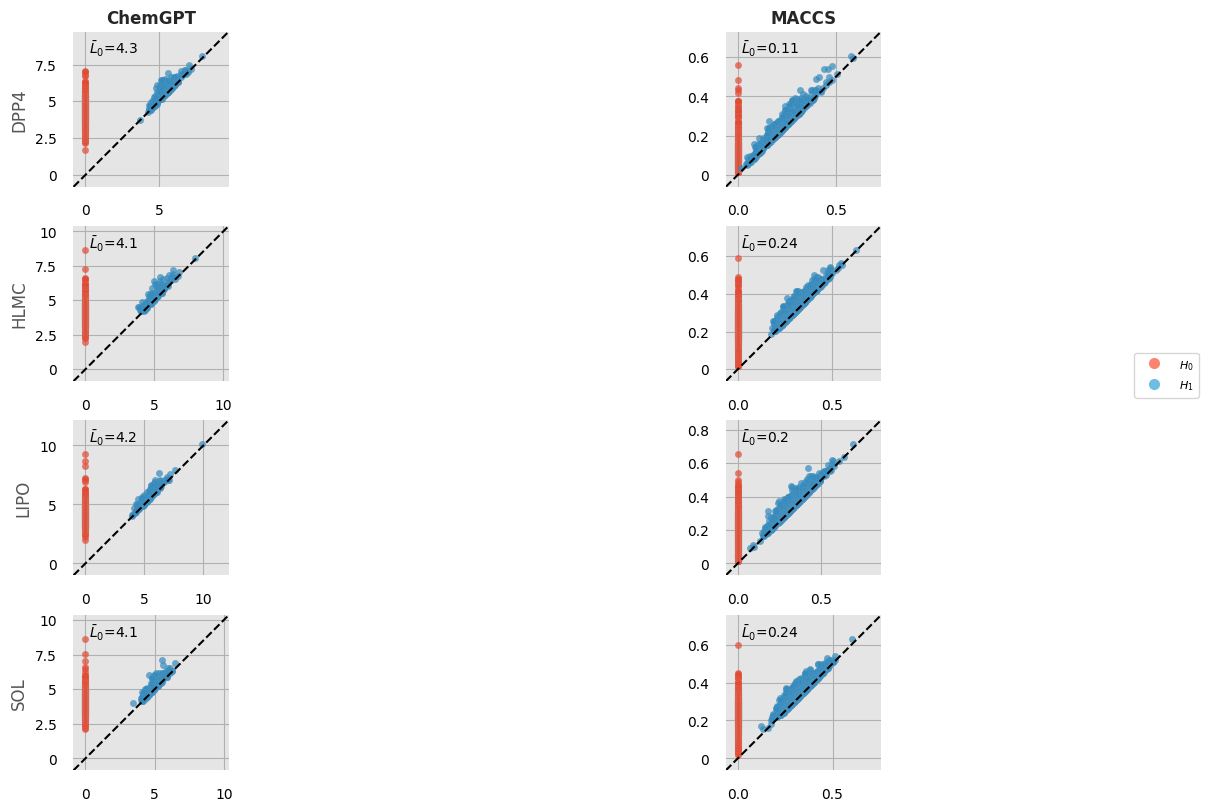

100%|██████████| 3/3 [00:51<00:00, 17.20s/it]


In [4]:
from tqdm import tqdm

# Generate some diagrams for supplementary information
# Due to the number of combinations, not all will be shown
reps = ['ChemBERTa', 'ECFP4', 'Mol2Vec', 'TOPO', 'MolProp', "GIN",  
        'Combined', 'Pharm2D', 'PubChem', 'MAP4', 'MACCS', 'ChemGPT']
datasets = df.dataset.unique()
max_cols = 5
max_rows = 8

for i in tqdm(range(0, len(reps), max_cols)):
    selected_reps = reps[i:i+max_cols]
    for j in range(0, len(datasets), max_rows):
        selected_dats = datasets[j:j+max_rows].tolist()

        filter = {
                "samples": 1000,
                "split": "random",
                "representation": selected_reps,
                "dataset": selected_dats
        }

        subset = filter_df(df, filter)
        subset = subset.sort_values(by=["dataset", "representation"])

        # Check if they have the same shape
        group_sizes = subset.groupby(["dataset"])["representation"].size().values
        if not all(x==group_sizes[0] for x in group_sizes):
            for i in range(subset.representation.nunique()):
                print(subset.groupby(["dataset"])["representation"].nth(i)) 
            raise Exception

        load_plot_config()
        plt.style.use('ggplot')

        fig = create_subplots(subset, plot_ph_diagrams, 
                            n_cols=subset["representation"].nunique(),
                            col_labels=subset["representation"].values,
                            row_labels=subset["dataset"].unique(),
                            ncols_legend=1, 
                            bbox_to_anchor=(1, 0.5),
                            figsize=(13, 2), kwargs={"colormap": "default",
                                                    "size": 25, "palette": {r"$H_0$": "#fc4f3012", r"$H_1$": "#30a2da"},
                                                    "alpha": 0.7, "markeredgecolor": "lightgrey", "markeredgewidth": 0.05})
        fig.set_facecolor('white')
        fig.figure.savefig(f'plots/ph_diagrams_{i}_{j}.png', bbox_inches='tight', dpi=300)

#### Plot 2: Log-log plot of fractal dimension slope

[4 4 4]


 67%|██████▋   | 8/12 [00:00<00:00, 11.66it/s]

100%|██████████| 12/12 [00:01<00:00, 11.65it/s]


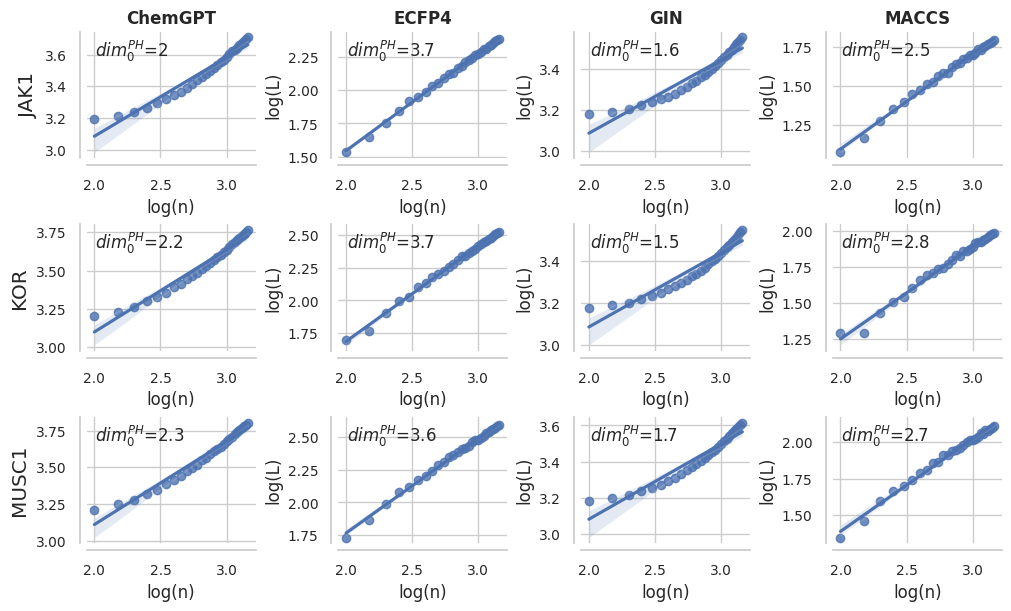

In [3]:
from utils import plot_phdim_fractals

load_plot_config()
filter = {
        "samples": 1500,
        "split": "scaffold",
        "representation": ["ECFP4", "MACCS", "ChemGPT", "RAND", "GIN"],
        "dataset": ["MUSC1", "KOR", "JAK1"],
        "representation_type": {"all": None},
        "distance_metric": {"all": None}
}

subset = filter_df(df, filter)
subset = subset.sort_values(by=["dataset", "representation"])

# Check if they have the same shape
group_sizes = subset.groupby(["dataset"])["representation"].size().values
print(group_sizes)
if not all(x==group_sizes[0] for x in group_sizes):
    for i in range(subset.representation.nunique()):
        print(subset.groupby(["dataset"])["representation"].nth(i)) 
    raise Exception

fig = create_subplots(subset, plot_phdim_fractals, 
                n_cols=subset["representation"].nunique(),
                col_labels=subset["representation"].values,
                row_labels=subset["dataset"].unique(),
                figsize=(10, 2),
                kwargs={"dim": 0})
fig.figure.savefig('plots/phdim.png', dpi=300)

#### Plot 3: Lifetime distribution per representation and dataset

100%|██████████| 40/40 [00:26<00:00,  1.50it/s]


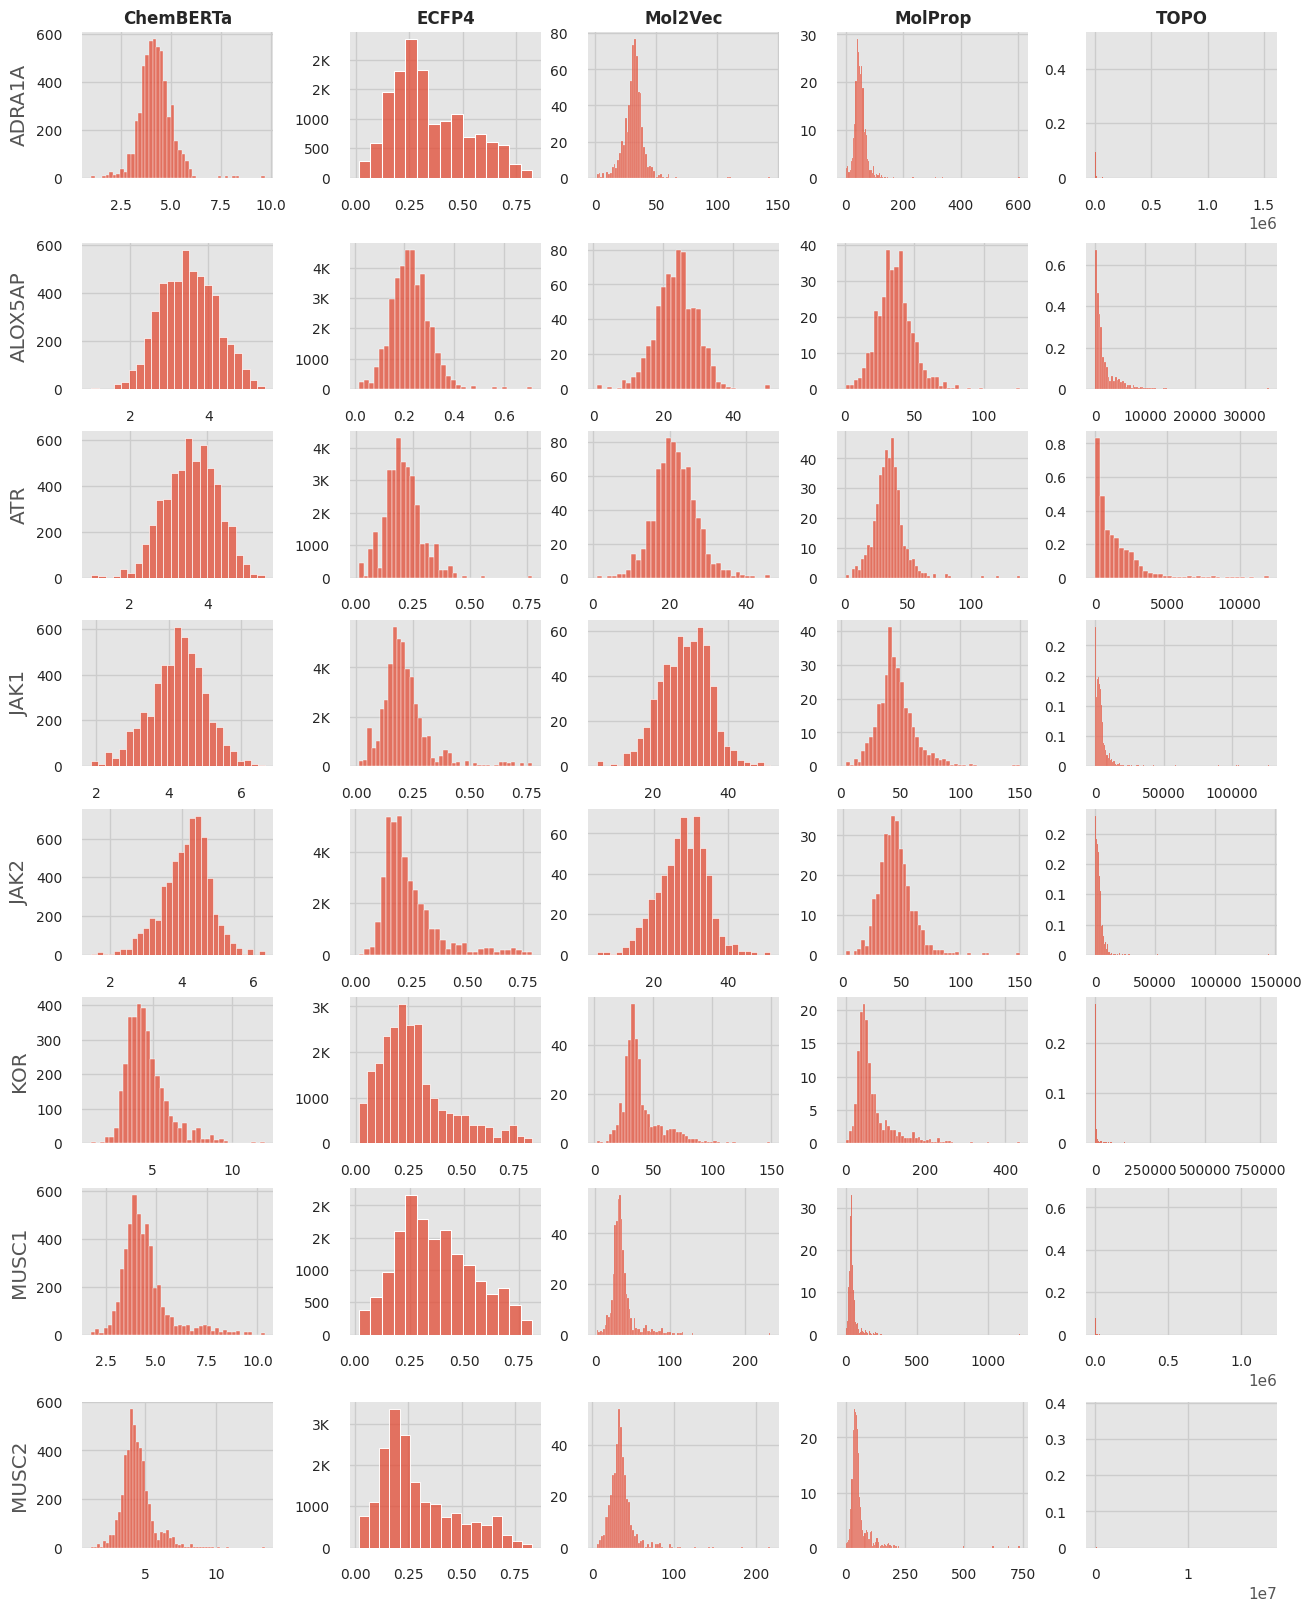

100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


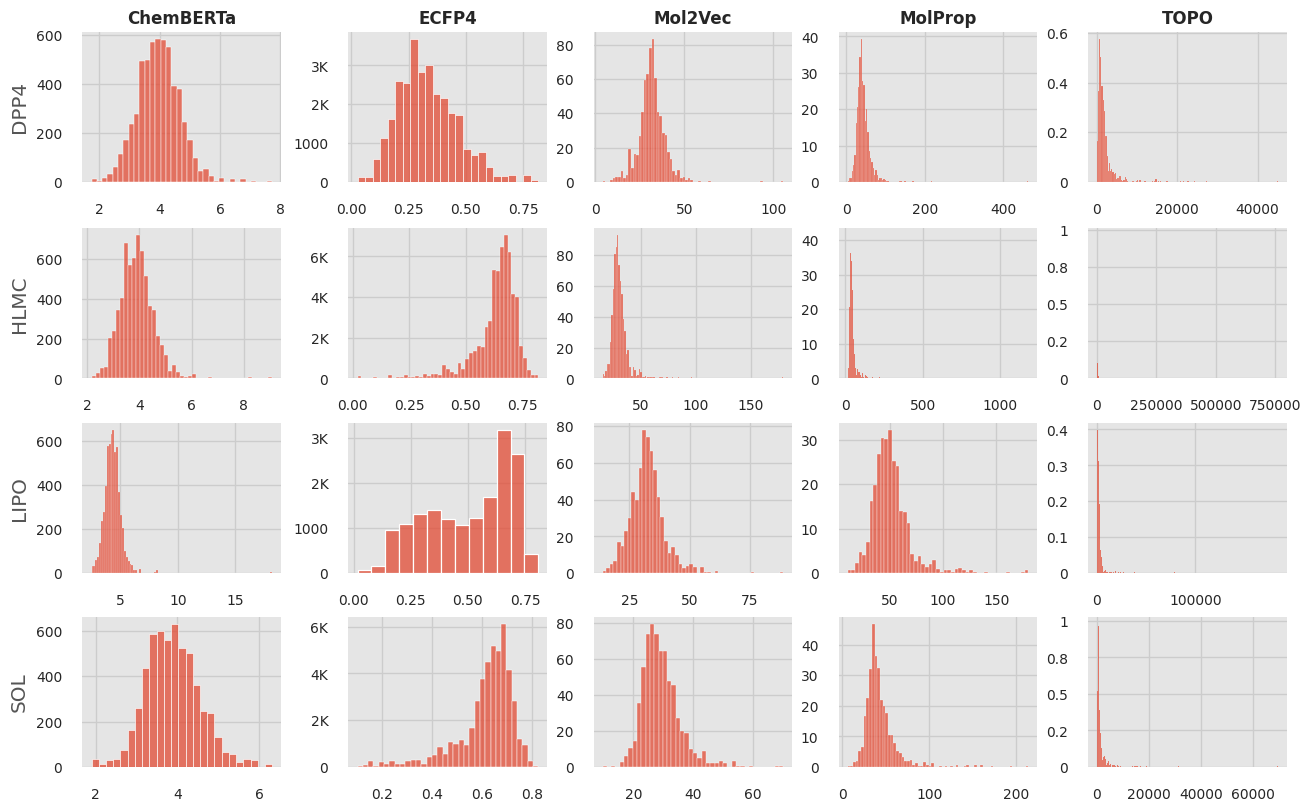

100%|██████████| 40/40 [00:27<00:00,  1.46it/s]


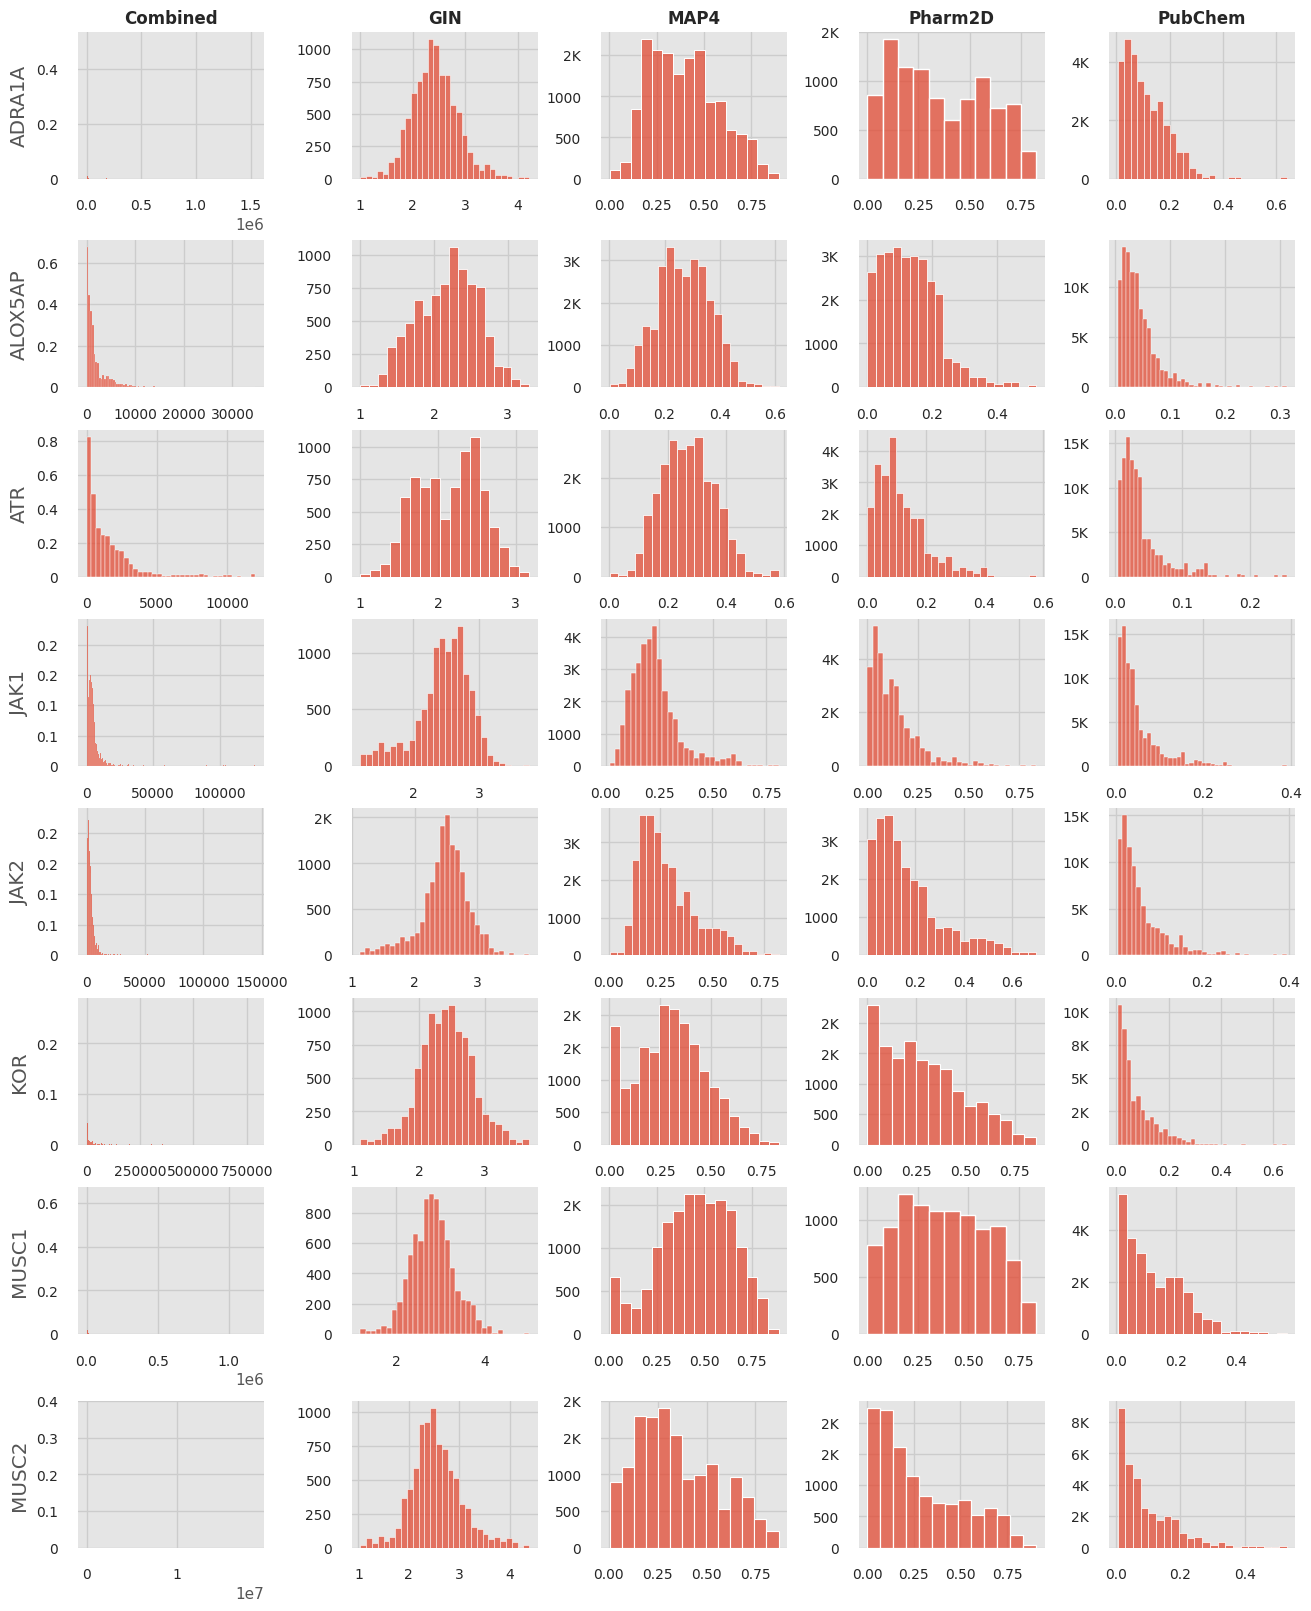

100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


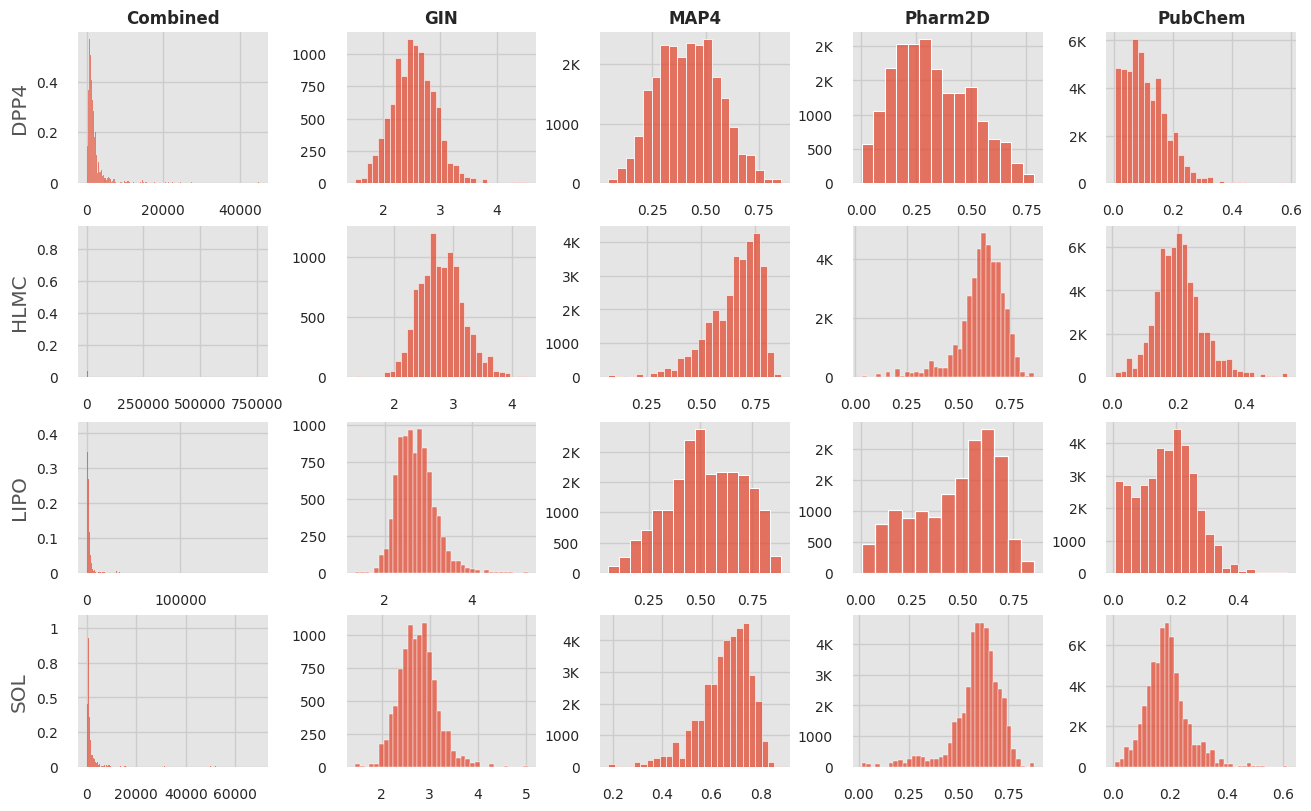

100%|██████████| 16/16 [00:01<00:00, 12.54it/s]


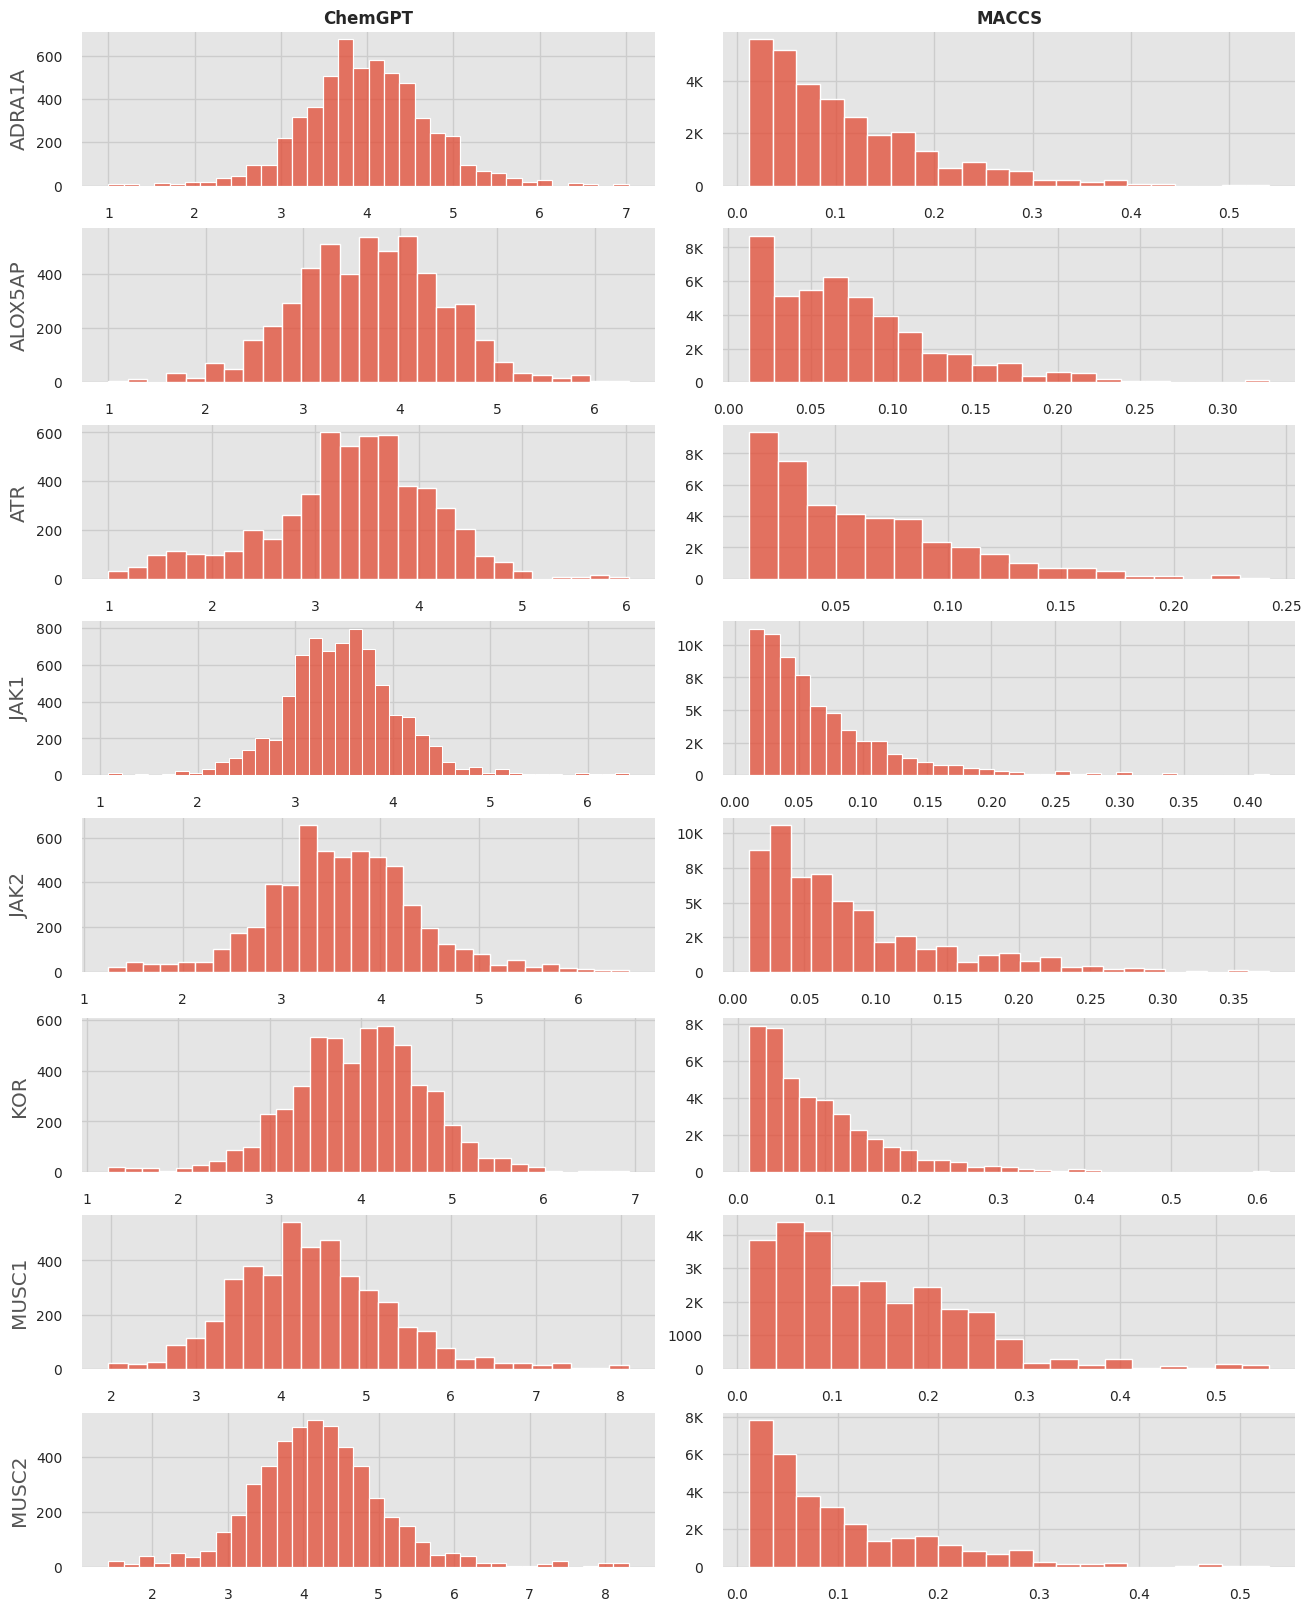

100%|██████████| 8/8 [00:00<00:00, 16.62it/s]


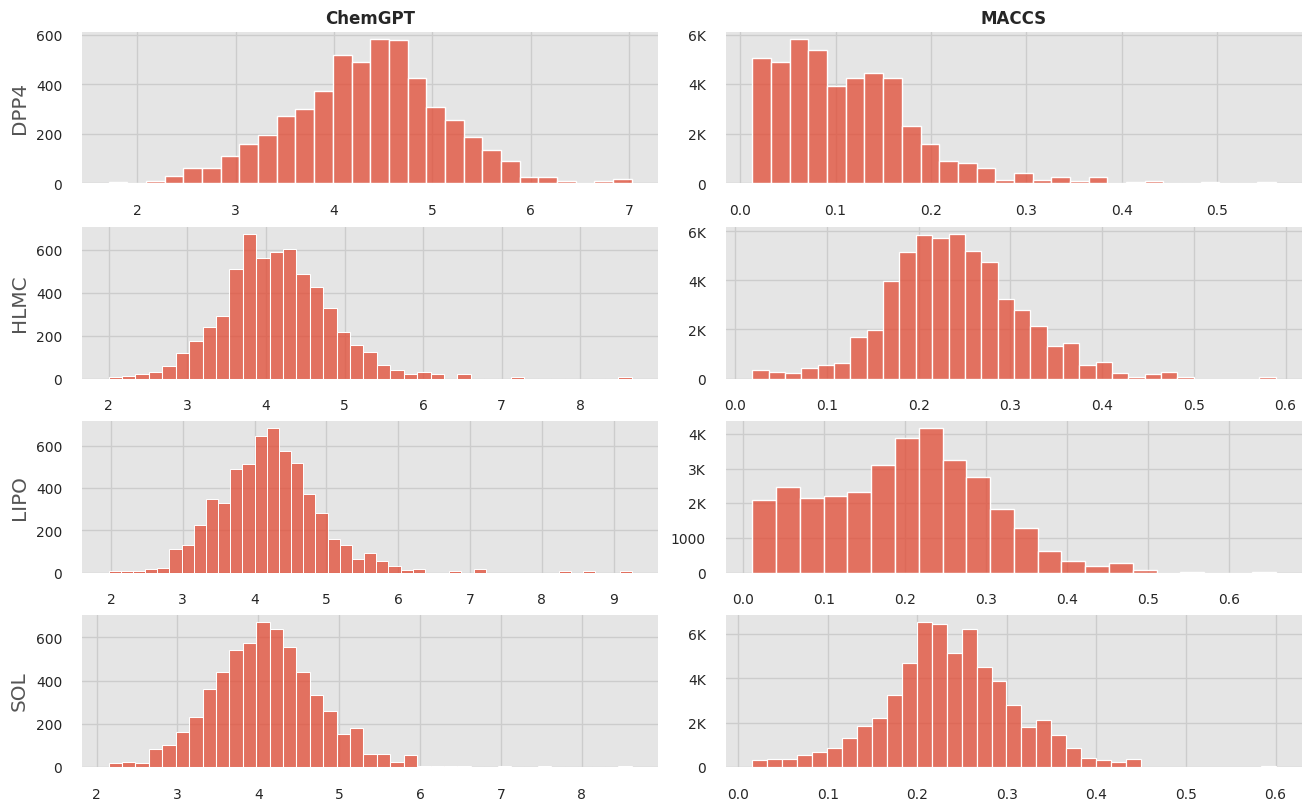

100%|██████████| 3/3 [02:34<00:00, 51.42s/it]


In [5]:
from tqdm import tqdm
from utils import plot_ph_interval_hist

# Generate some diagrams for supplementary information
# Due to the number of combinations, not all will be shown
reps = ['ChemBERTa', 'ECFP4', 'Mol2Vec', 'TOPO', 'MolProp', "GIN",  
        'Combined', 'Pharm2D', 'PubChem', 'MAP4', 'MACCS', 'ChemGPT']
datasets = df.dataset.unique()
max_cols = 5
max_rows = 8

for i in tqdm(range(0, len(reps), max_cols)):
    selected_reps = reps[i:i+max_cols]
    for j in range(0, len(datasets), max_rows):
        selected_dats = datasets[j:j+max_rows].tolist()
                
        filter = {
                "samples": 1000,
                "split": "scaffold",
                "representation": selected_reps,
                "dataset": selected_dats,
                "representation_type": {"all": None},
                "distance_metric": {"all": None}
        }

        subset = filter_df(df, filter)
        subset = subset.sort_values(by=["dataset", "representation"])

        # Check if they have the same shape
        group_sizes = subset.groupby(["dataset"])["representation"].size().values
        if not all(x==group_sizes[0] for x in group_sizes):
            for i in range(subset.representation.nunique()):
                print(subset.groupby(["dataset"])["representation"].nth(i)) 
            raise Exception

        load_plot_config()
        plt.style.use('ggplot')
        fig = create_subplots(subset, plot_ph_interval_hist, 
                        n_cols=subset["representation"].nunique(),
                        col_labels=subset["representation"].unique(),
                        row_labels=subset["dataset"].unique(),
                        figsize=(13, 2))
        fig.set_facecolor('white')
        fig.figure.savefig(f'plots/lifetime_dist_{i}_{j}.png', bbox_inches='tight', dpi=300)

#### Plot 4: Persistence diagramm for each representation over sample size

100%|██████████| 25/25 [00:01<00:00, 12.59it/s]


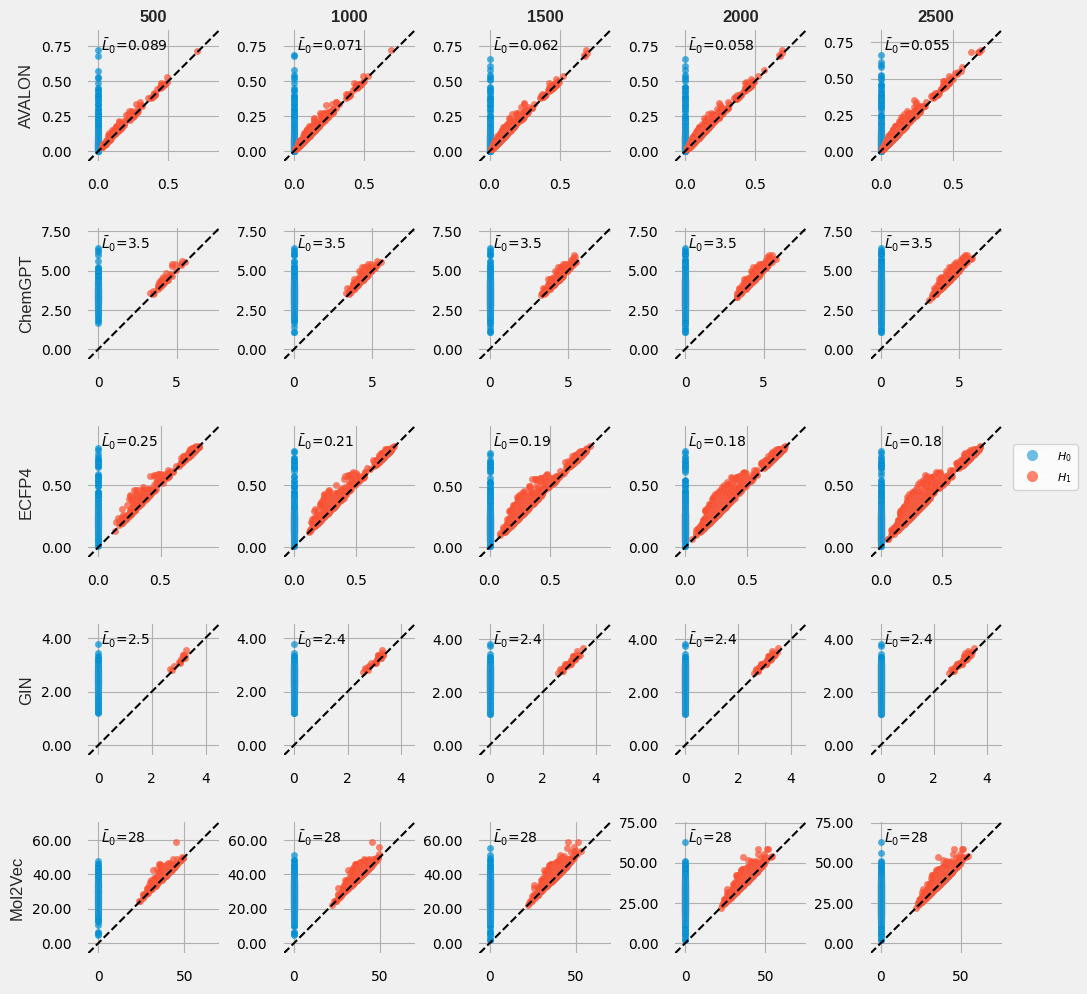

In [5]:
from matplotlib import rc
plt.rcParams['font.family'] = 'Liberation Sans'
rc('text', usetex=False) 

filter = {
        "split": "scaffold",
        "representation": ["AVALON", "Mol2Vec", "GIN", "ChemGPT", "ECFP4"],
        "dataset": "JAK1",
        "representation_type": {"all": None},
        "distance_metric": {"all": None}
}

subset = filter_df(df, filter)
subset = subset.sort_values(by=["representation", "samples"])


plt.style.use('fivethirtyeight')
fig = create_subplots(subset, plot_ph_diagrams, 
                n_cols=subset["samples"].nunique(),
                col_labels=subset["samples"].unique(),
                row_labels=subset["representation"].unique(),
                ncols_legend=1,
                figsize=(10, 2), kwargs={"colormap": "default",
                                             "size": 25, "palette": {r"$H_0$": "#30a2da", r"$H_1$": "#fc4f3012"},
                                             "alpha": 0.7, "markeredgecolor": "lightgrey", "markeredgewidth": 0.05})
fig.set_facecolor('white')
fig.figure.savefig(f'plots/ph_samples.png', bbox_inches='tight', dpi=300)

#### Plot 5: Log-log fractal dimension for each representation over sample size

[5 5 5]


100%|██████████| 15/15 [00:01<00:00, 10.44it/s]


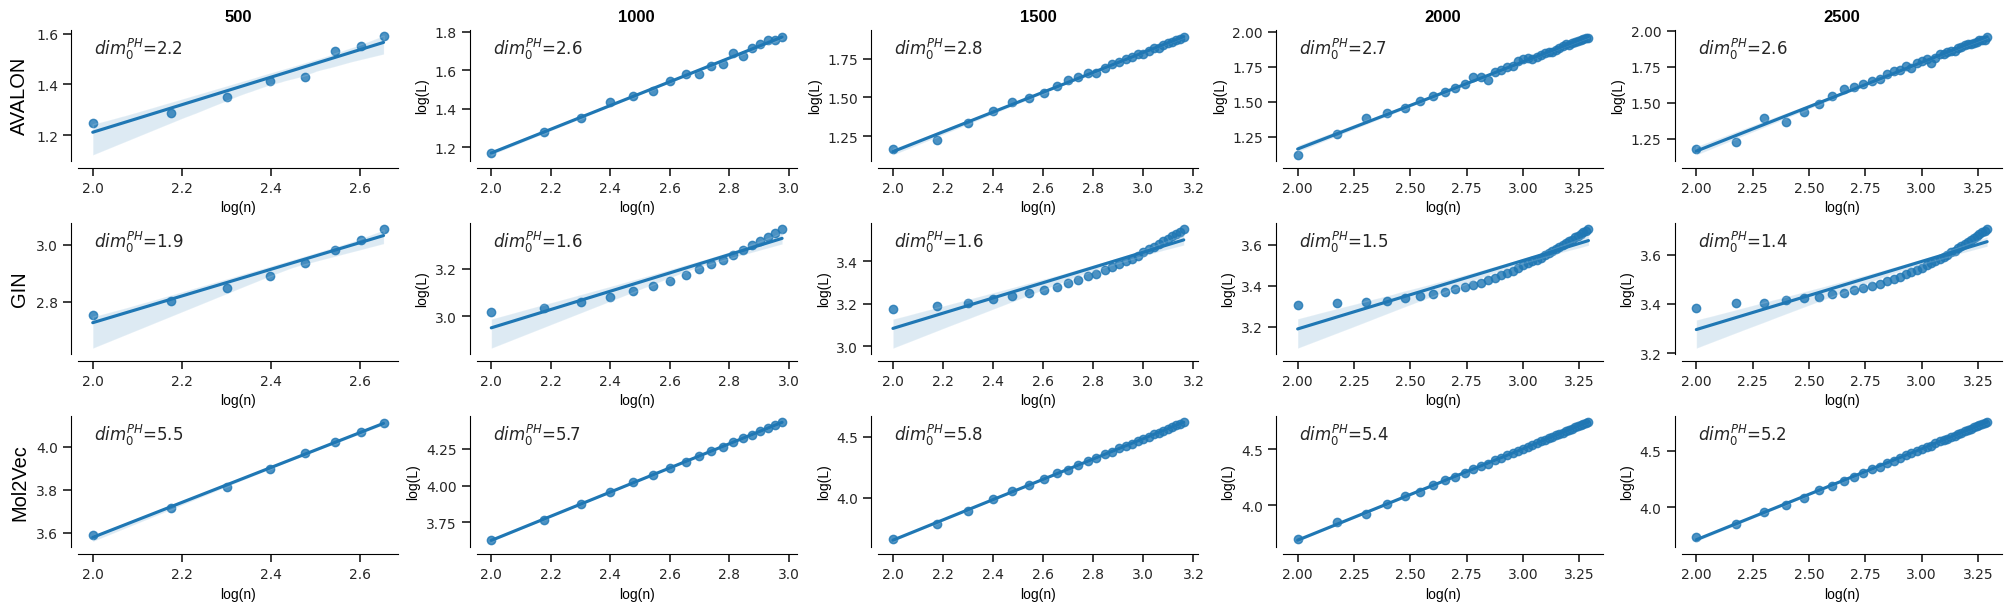

In [6]:
from matplotlib import rc
from utils import plot_phdim_fractals
plt.rcParams['font.family'] = 'Liberation Sans'

rc('text', usetex=False) 

filter = {
        "split": "random",
        "representation": ["AVALON", "Mol2Vec", "GIN"],
        "dataset": "JAK1",
        "representation_type": {"all": None},
        "distance_metric": {"all": None}
}


subset = filter_df(df, filter)
subset = subset.sort_values(by=["representation", "samples"])

# Check if they have the same shape
group_sizes = subset.groupby(["representation"])["samples"].size().values
print(group_sizes)
if not all(x==group_sizes[0] for x in group_sizes):
    for i in range(subset.representation.nunique()):
        print(subset.groupby(["representation"])["samples"].nth(i).reset_index()) 
    raise Exception

fig = create_subplots(subset, plot_phdim_fractals, 
                n_cols=subset["samples"].nunique(),
                col_labels=subset["samples"].unique(),
                row_labels=subset["representation"].unique(),
                figsize=(20, 2),
                kwargs={"dim": 0})

#### Plot 6: PHD convergence based on sample size

100%|██████████| 5/5 [00:00<00:00, 25.68it/s]


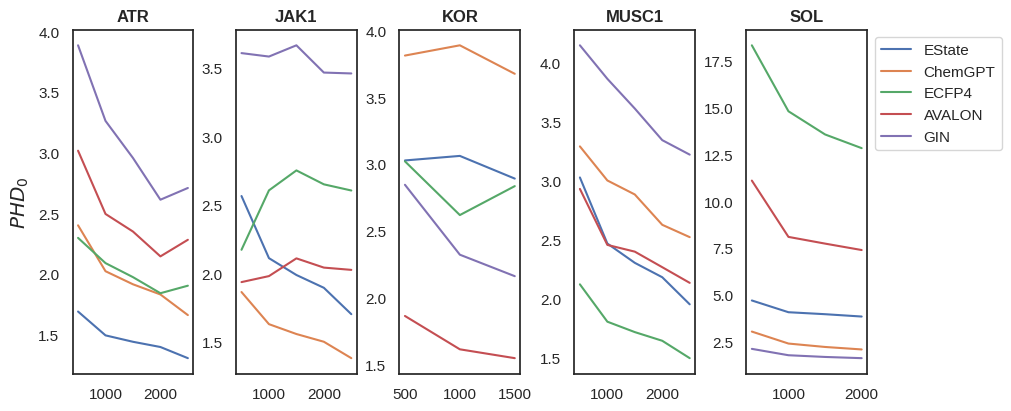

In [10]:
from functools import reduce
import numpy as np
from utils import plot_phd_samples
plt.rcParams['font.family'] = 'Liberation Sans'


hue = "Representation"
stat = "samples"
metric = "PHD"


filter = {
        "split": "scaffold",
        "representation": ["ChemGPT", "GIN", "ECFP4", "AVALON", "EState"],
        "dataset": ["MUSC1", "KOR", "JAK1", "ATR", "SOL"],
        "representation_type": {"all": None},
        "distance_metric": {"all": None}
}


subset = filter_df(df, filter)

s = subset.groupby("dataset")["representation"].apply(np.array).reset_index(name=hue)
e = subset.groupby("dataset")["ph_dim_0"].apply(np.array).reset_index(name=metric)
h = subset.groupby("dataset")[stat].apply(np.array).reset_index(name=stat)
plt_data = reduce(lambda  left, right: pd.merge(left, right, on=['dataset'],
                                            how='outer'), [s, e, h])

fig = create_subplots(plt_data, plot_phd_samples, 
                n_cols=plt_data["dataset"].nunique(),
                col_labels=plt_data["dataset"].values,
                row_labels=[r"$PHD_0$"],
                figsize=(10, 4), kwargs={"stat": stat, "metric": metric, "rep": "Representation"})

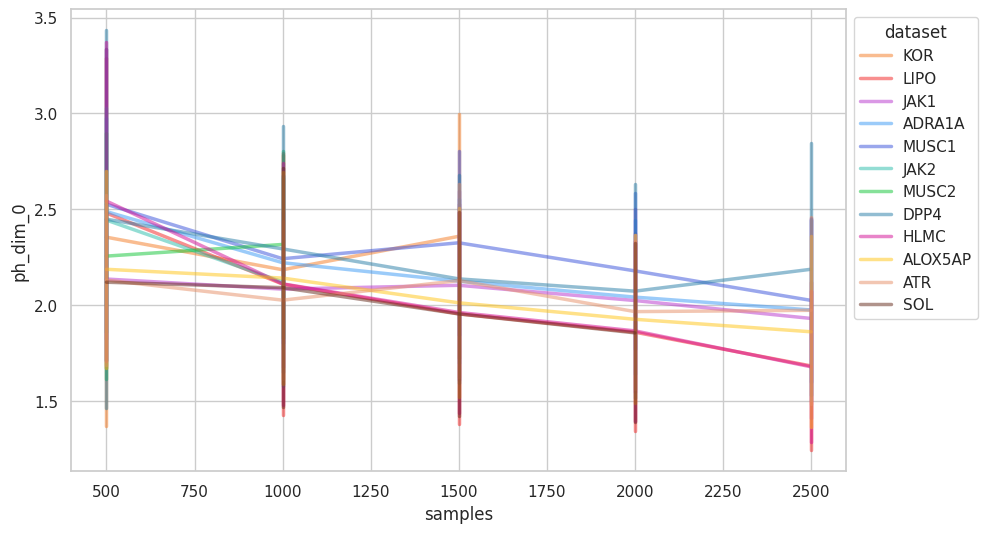

In [18]:
from plotting import get_palettes, load_plot_config

filter = {
        "split": "scaffold",
        "ph_dim_0": {"gte": 0},
        "ph_dim_0": {"lte": 3},
        "representation": ["ChemGPT", "GIN", "ECFP4", "AVALON", "EState"],
        "representation_type": {"all": None},
        "distance_metric": {"all": None}
}


subset = filter_df(df, filter)

_, dataset_colors = get_palettes()

sns.set_theme(rc={'figure.figsize':(10, 6)})
load_plot_config()
p = sns.lineplot(subset, x='samples', y="ph_dim_0", hue="dataset", linewidth=2.5, alpha=0.5, err_kws={'elinewidth': 2.5},
             err_style='bars', errorbar=('se', 2), palette=sns.color_palette(dataset_colors.values()))
sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))

#### Plot 7: Wasserstein distance between persistence diagrams

100%|██████████| 17/17 [02:17<00:00,  8.08s/it]


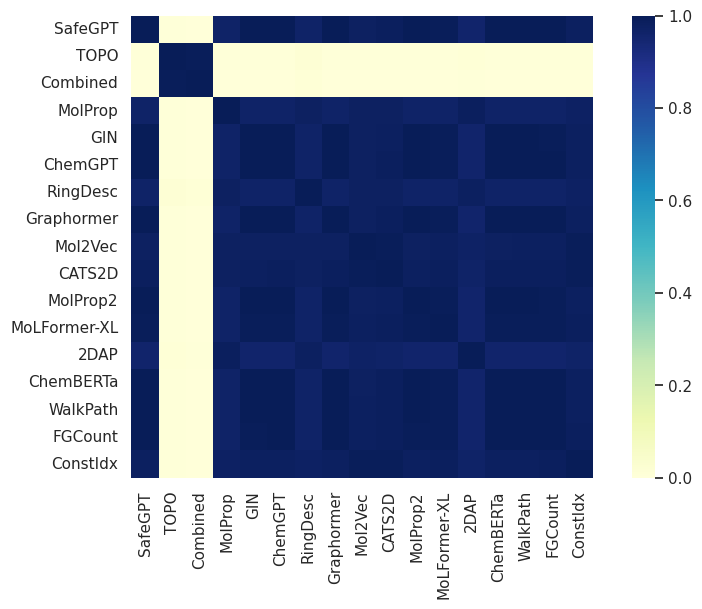

In [19]:
import persim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams['font.family'] = 'Liberation Sans'


filter = {
    "samples": 2000,
    "split": "scaffold",
    "distance_metric": "euclidean",
    "dataset": "ATR",
}

dimension = 0
subset = filter_df(df, filter)
mat_elements = []
dgms = subset["dgms"].values
names = subset["representation"]
for src in tqdm(dgms):
    for trgt in dgms:
        mat_elements.append(persim.sliced_wasserstein(src[dimension], trgt[dimension]))

dist_mat = np.array(mat_elements).reshape(len(dgms), len(dgms))
mask = np.zeros_like(dist_mat)
mask[np.triu_indices_from(mask)] = True


# Similarity matrix
with sns.axes_style("white"):
    ax = sns.heatmap(1 - (dist_mat / dist_mat.max()), square=True,  cmap="YlGnBu", xticklabels=names, yticklabels=names) # mask=mask
    plt.show()

#### Plot 8: Distance between Persistence Landscape

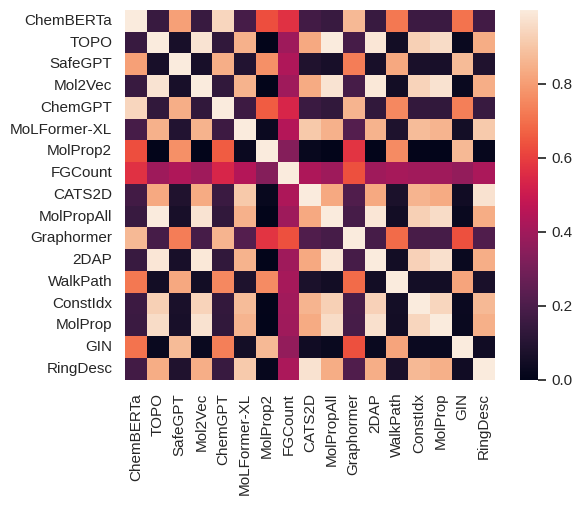

In [34]:
from sklearn.metrics import pairwise_distances
from persim.landscapes import PersistenceLandscaper

ple0s = []
for dgm in dgms:
    pl = PersistenceLandscaper(hom_deg=0, start=0, stop=7.0, num_steps=500, flatten=True)
    ple0s.append(pl.fit_transform(dgm))

max_len = max([p.shape[0] for p in ple0s])
padded_pl = [np.pad(p, (0, max_len-p.shape[0]), constant_values=(0, 0)) for p in ple0s]
pairwise_distance = pairwise_distances(padded_pl)

sns.heatmap(1 - (pairwise_distance / pairwise_distance.max()),  square=True,  xticklabels=names, yticklabels=names) 
plt.show()